In [25]:
import json
import scipy.stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FastICA, KernelPCA
from matplotlib import cm
from sklearn.metrics import rand_score, silhouette_score, fowlkes_mallows_score, calinski_harabasz_score, \
    homogeneity_score, mutual_info_score, davies_bouldin_score, v_measure_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from concurrent.futures import ThreadPoolExecutor
from sklearn.random_projection import  GaussianRandomProjection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif,mutual_info_classif,chi2
import yellowbrick.features.pca

from sklearn.preprocessing import LabelEncoder
import yellowbrick.cluster

In [2]:
df1 = pd.read_csv("data/Dataset_Handwritten_English/flattened_images_30x40.csv",low_memory=False)

y = df1['label'].astype(str)
X = df1.drop(['label'],axis=1)
_y_unique_labels = y.unique().shape[0]
y=LabelEncoder().fit_transform(y)

X_train,X_test,y_train,y_test = train_test_split(X,y)

In [3]:
save_prefix="analysis/images/"

## ICA

In [4]:
kurt=scipy.stats.kurtosis(X_train)
kmean=kurt.mean()
print(kurt)
print(kmean)

[-3. -3. -3. ... -3. -3. -3.]
611.7823248373201


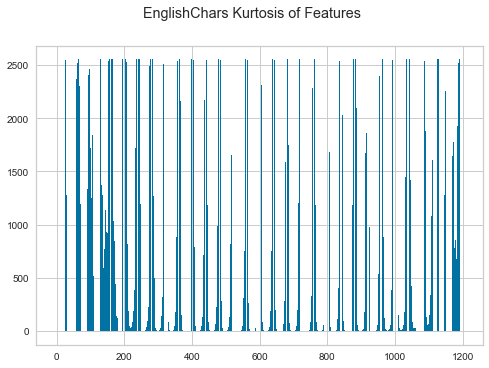

In [5]:
title=f"EnglishChars Kurtosis of Features"
x_points = [i for i in range(len(kurt))]
y_points = kurt
plt.bar(x_points,y_points)
plt.suptitle(title)
savepath=f"{save_prefix}{title.replace(' ','_')}.png"
plt.savefig(savepath)
plt.show()

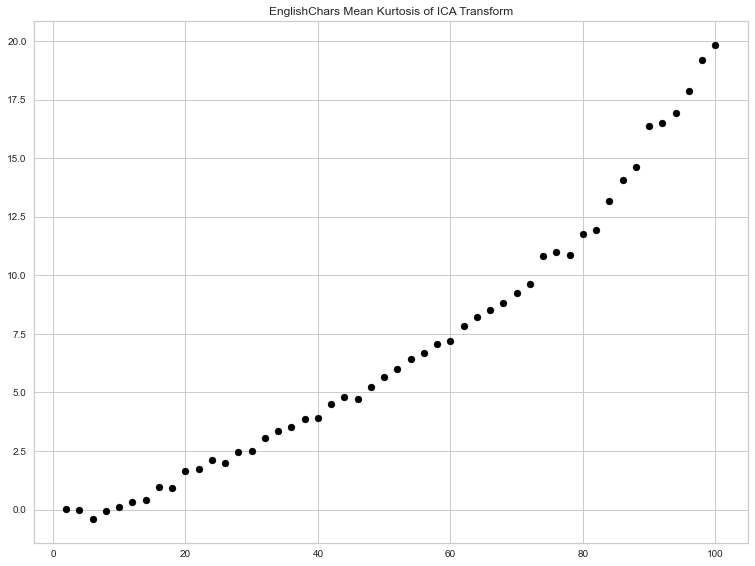

In [6]:
title=f"EnglishChars Mean Kurtosis of ICA Transform 100 step 2"
kurt = []
for i in range(2,102,2):
    ica_x=FastICA(n_components=i,
            whiten=True,
            fun="cube",max_iter=500,tol=1e-1).fit_transform(X_train)
    kurt.append((i,scipy.stats.kurtosis(ica_x).mean()))

fig = plt.figure(figsize=(12.8,9.6))
ax=fig.add_subplot()
ax.set_title(title)
for i,k in kurt:
    ax.scatter(x=i,y=k,color='black')
fig.savefig(f"{save_prefix}{title.replace(' ','_')}.png")
plt.show()

c:\users\james\pycharmprojects\ml_hw_03\venv\lib\site-packages\sklearn\decomposition\_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


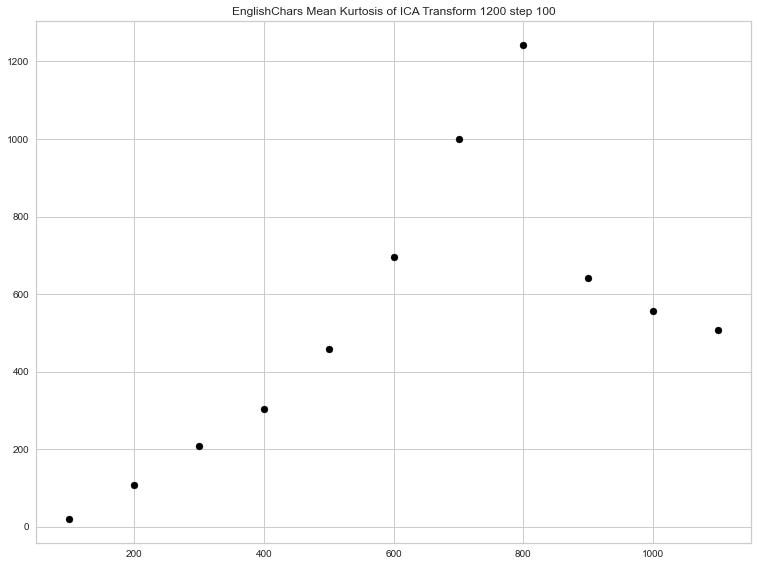

In [23]:
title=f"EnglishChars Mean Kurtosis of ICA Transform 1200 step 100"
kurt = []
for i in range(100,1200,100):
    ica_x=FastICA(n_components=i,
            whiten=True,
            fun="cube",max_iter=500,tol=1e-1).fit_transform(X_train)
    kurt.append((i,scipy.stats.kurtosis(ica_x).mean()))

fig = plt.figure(figsize=(12.8,9.6))
ax=fig.add_subplot()
ax.set_title(title)
for i,k in kurt:
    ax.scatter(x=i,y=k,color='black')
fig.savefig(f"{save_prefix}{title.replace(' ','_')}.png")
plt.show()

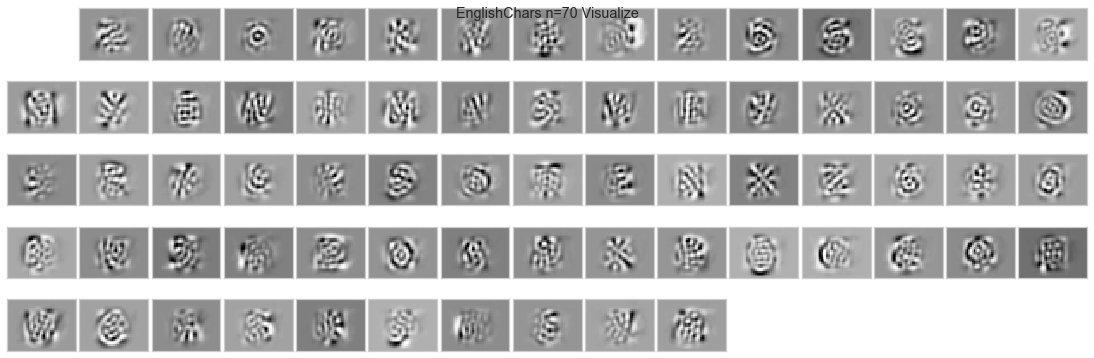

In [7]:

ica=FastICA(n_components=70,  # from graph above
            whiten=True,
            fun="cube").fit(X_train)  #Selected cube as it gave the best output based on the visualization
ica_x = ica.transform(X_train)
ncomponents = len(ica.components_)

title=f"EnglishChars n=70 Visualize"
cols=5
rows=1+ncomponents//cols
fig = plt.figure(figsize=(rows,cols))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(1,ncomponents):
    ax = fig.add_subplot(cols, rows, i + 1, xticks=[], yticks=[])
    ax.imshow(np.reshape(ica.components_[i, :], (30, 40)), cmap=plt.cm.Greys, interpolation='nearest')
plt.suptitle(title)
plt.savefig(f"{save_prefix}{title.replace(' ','_')}.png")
plt.show()


## PCA

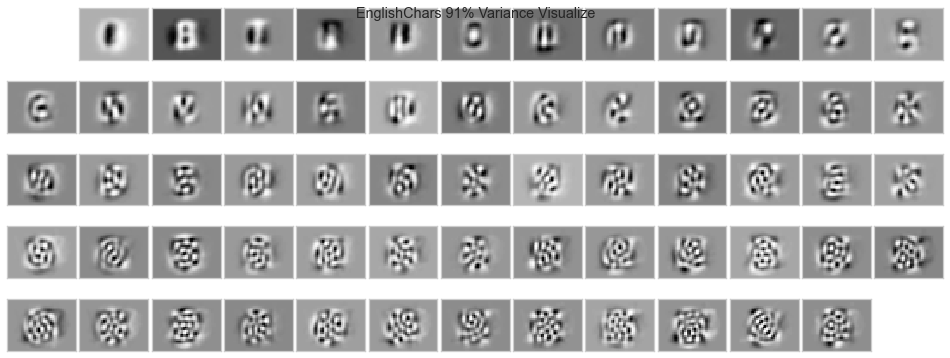

In [8]:
pca=PCA(0.91).fit(X_train)
pca_x = pca.transform(X_train)
ncomponents = len(pca.components_)

title=f"EnglishChars 91% Variance Visualize"
cols=5
rows=1+ncomponents//cols
fig = plt.figure(figsize=(rows,cols))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(1,ncomponents):
    ax = fig.add_subplot(cols, rows, i + 1, xticks=[], yticks=[])
    #ax.imshow(np.reshape(pca.components_[i, :], (900, 1200)), cmap=plt.cm.bone, interpolation='nearest')
    ax.imshow(np.reshape(pca.components_[i, :], (30, 40)), cmap=plt.cm.Greys, interpolation='nearest')
plt.suptitle(title)
plt.savefig(f"{save_prefix}{title.replace(' ','_')}.png")
plt.show()

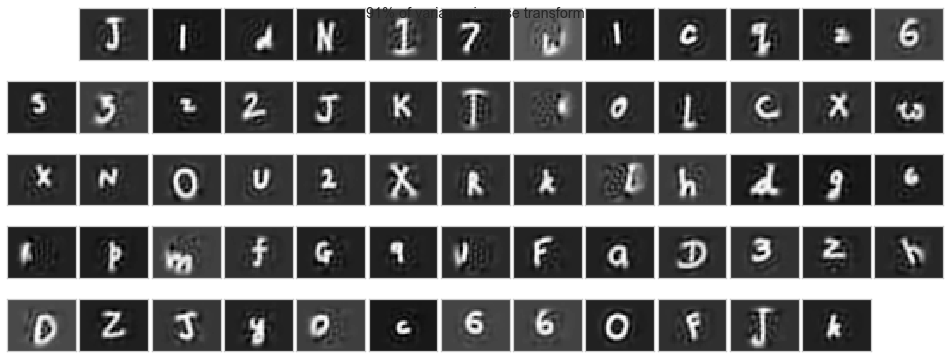

In [9]:
# Inverse transform to see how well this is applied to the model

pca_inv_x = pca.inverse_transform(pca_x)
cols=5
rows=1+ncomponents//cols
fig = plt.figure(figsize=(rows,cols))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(1,ncomponents):
    ax = fig.add_subplot(cols, rows, i + 1, xticks=[], yticks=[])
    ax.imshow(np.reshape(pca_inv_x[i, :], (30, 40)), cmap=plt.cm.Greys, interpolation='nearest')
plt.suptitle(f"91% of variance inverse transform")
#plt.savefig(f"analysis/images/PCA-Images-{percent_variance:0.2f}-{ncomponents}components.png")
plt.show()


In [10]:
internal_scoring_algos = {
    "si":silhouette_score,  #  measure of how tight clusters are, and how spread out they are. -1 to 1 (best)
    "ch":calinski_harabasz_score,  #  Ratio of cluster tightness to cluster dispersion.  higher ratio is tighter, more dispersed clusters
    "db":davies_bouldin_score  # measures tightness and cluster dispersion, the lower the value, the tighter and further apart they are
}
external_scoring_algos = {
    "fm":fowlkes_mallows_score,
    "hs":homogeneity_score,  # measure of how consistently samples of a given ground truth are placed into the correct cluster
    "mi":mutual_info_score,  # Determines the similarity between clusters by examining samples within different clusters and their similarity
    "rs":rand_score,  #  Measures similarity between two clusterings by considering all pairs and determining what has been assigned to same, or different, clusters
    "vs":v_measure_score, #  Measures cluster labeling to truthful labeling, irregardless of permutations of labels
}

## Clustering Selection

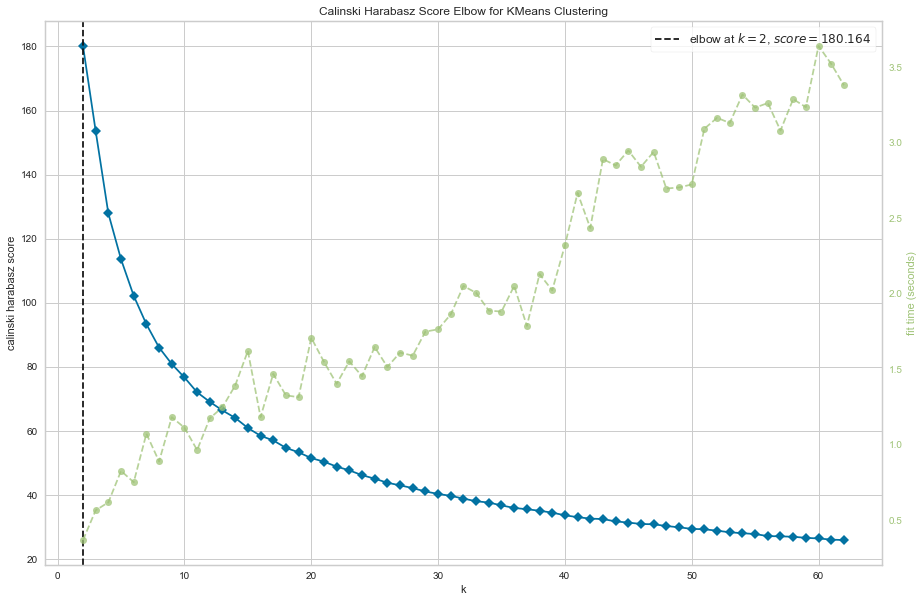

In [11]:
outpath=f"{save_prefix}EnglishChars_Calinski_Harabasz_Score_Eblow_Kmeans.png"
viz = yellowbrick.cluster.elbow.KElbowVisualizer(
    estimator=KMeans(),
    k=_y_unique_labels,
    metric='calinski_harabasz',   # I want to optimize this for tight clusters that are far apart
    timings=True,
    locate_elbow=True,
    size=(1080, 720)
)
viz.fit(X_train)
viz.show(outpath=outpath)
viz.show()
k_optimal1=viz.elbow_value_


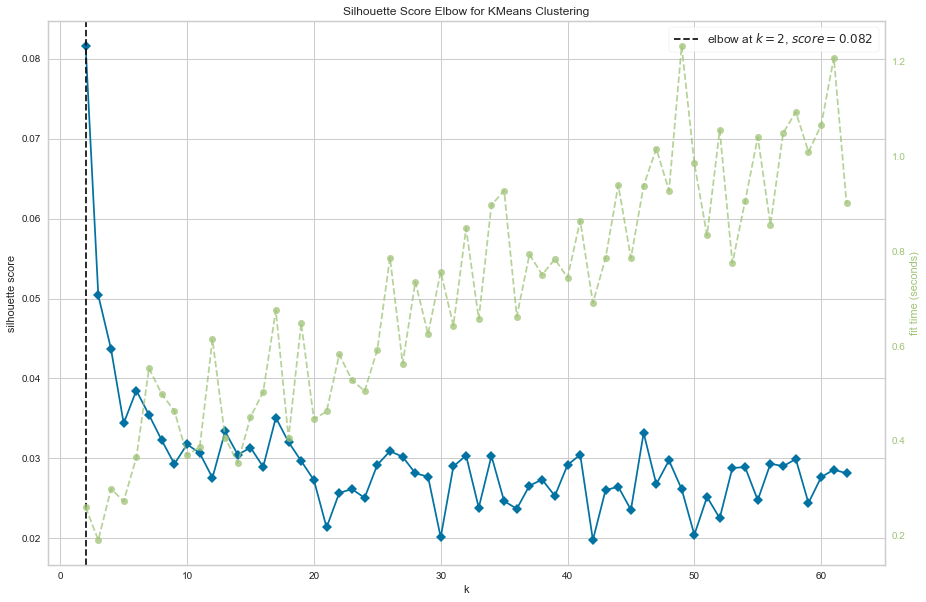

In [12]:
outpath=f"{save_prefix}EnglishChars_Silhouette_Score_Eblow_Kmeans.png"
viz = yellowbrick.cluster.elbow.KElbowVisualizer(
    estimator=KMeans(n_clusters=_y_unique_labels,n_init=3,copy_x=True,algorithm='auto'),
    k=_y_unique_labels,
    metric='silhouette',   # I want to optimize this for tight clusters that are far apart
    timings=True,
    locate_elbow=True,
    size=(1080, 720)
)
viz.fit(X_train)
viz.show(outpath=outpath)
viz.show()
k_optimal2=viz.elbow_value_


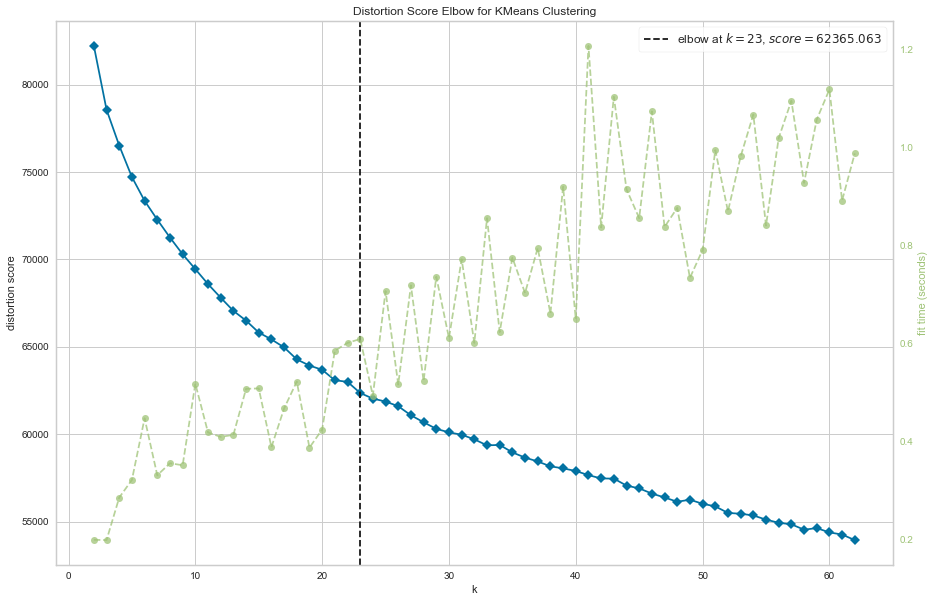

In [13]:
outpath=f"{save_prefix}EnglishChars_Distortion_Score_Eblow_Kmeans.png"
viz = yellowbrick.cluster.elbow.KElbowVisualizer(
    estimator=KMeans(n_clusters=_y_unique_labels,n_init=3,copy_x=True,algorithm='auto'),
    k=_y_unique_labels,
    metric='distortion',   # I want to optimize this for tight clusters that are far apart
    timings=True,
    locate_elbow=True,
    size=(1080, 720)
)
viz.fit(X_train)
viz.show(outpath=outpath)
viz.show()
k_optimal3=viz.elbow_value_

In [14]:
print(f"Optimals: {[k_optimal3,k_optimal2,k_optimal1]}")

Optimals: [23, 2, 2]


## Clustering Visualization

c:\users\james\pycharmprojects\ml_hw_03\venv\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


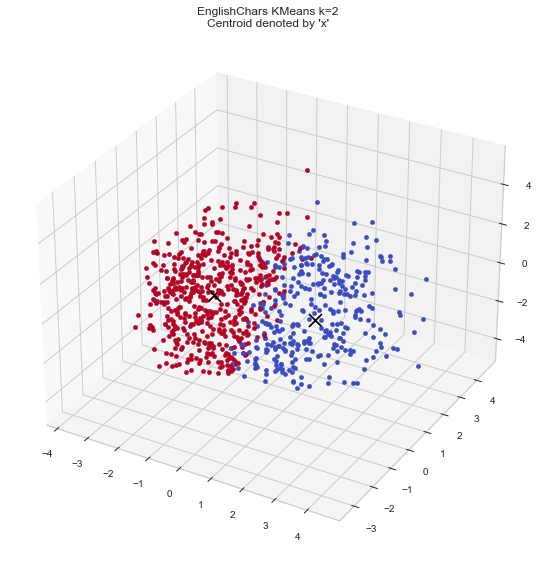

c:\users\james\pycharmprojects\ml_hw_03\venv\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


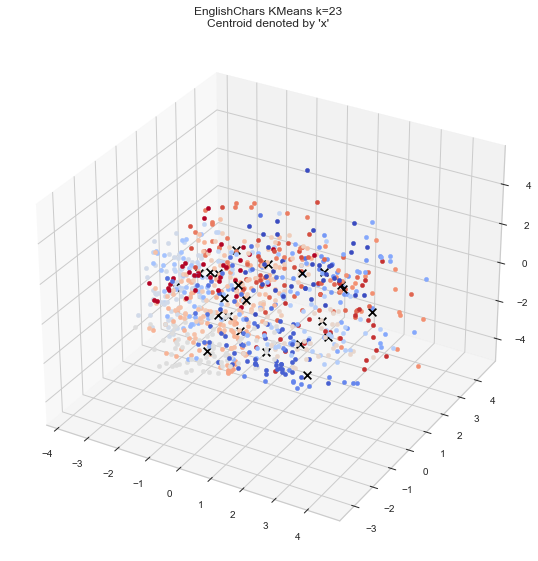

In [15]:
scores = {}
for k in set([k_optimal3,k_optimal2,k_optimal1]):
    model = KMeans(n_clusters=k,n_init=3,copy_x=True,algorithm='auto')
    model.fit(X_train)
    pred=model.predict(X_test)
    color_map = cm.get_cmap('coolwarm', k)
    pca = PCA(3).fit(X_test)
    x_points = pca.transform(X_test)
    centroids = pca.transform(model.cluster_centers_)
    fig = plt.figure(figsize=(12.8,9.6))
    ax = fig.add_subplot(projection='3d')
    ax.set_title(f"EnglishChars KMeans k={k}\nCentroid denoted by 'x'")
    for (x, y, z), label in zip(x_points, pred):
        color = color_map(label)
        ax.scatter(x,y,z,color=color,alpha=1.0)
    for i in range(len(centroids)):
        color='black'
        x,y,z=centroids[i]
        marker = 'x'
        ax.scatter(x,y,z,
                   color=color,
                   marker=marker,
                   alpha=1.0,
                   s=170-(len(centroids)**1.5))
    plt.show()
    internal_scores = {name:f(X_test,pred) for name,f in internal_scoring_algos.items()}
    external_scores = {name:f(y_test,pred) for name,f in external_scoring_algos.items()}
    scores[k]={
        "internal_scores":internal_scores,
        "external_scores":external_scores
    }

## Clustering Scoring

In [16]:
print(scores)

{2: {'internal_scores': {'si': 0.08285834564761087, 'ch': 55.975989555984164, 'db': 3.794877808548987}, 'external_scores': {'fm': 0.10320357633846487, 'hs': 0.027287617304513217, 'mi': 0.11194008757804343, 'rs': 0.47692485510955535, 'vs': 0.0469501437633887}}, 23: {'internal_scores': {'si': 0.023657828565015446, 'ch': 15.448528784847868, 'db': 2.970380727828746}, 'external_scores': {'fm': 0.08216352948755133, 'hs': 0.30851554712041523, 'mi': 1.265601792140911, 'rs': 0.9386203897869436, 'vs': 0.3539029309916841}}}


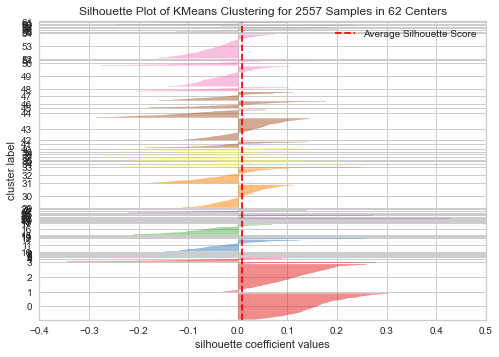

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 2557 Samples in 62 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [17]:
outpath=f"{save_prefix}EnglishChars_Silhouette_Plot.png"
scaler=StandardScaler().fit(X_train)
scaled_x=scaler.transform(X_train)
pca=PCA(0.91).fit(scaled_x)
pca_x = pca.transform(scaled_x)
viz = yellowbrick.cluster.SilhouetteVisualizer(
    estimator=KMeans(n_clusters=_y_unique_labels,n_init=3,copy_x=True,algorithm='auto'),
)
viz.fit(pca_x)
viz.show(outpath=outpath)
viz.show()


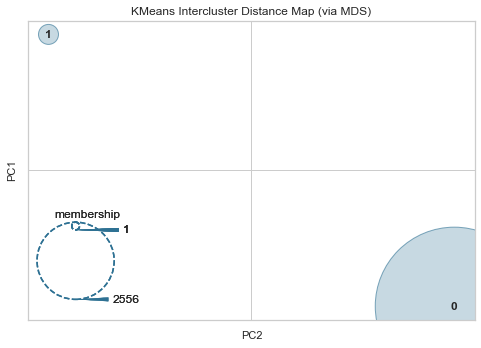

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [18]:
outpath=f"{save_prefix}EnglishChars_InterclusterDistance_k=2.png"
viz = yellowbrick.cluster.InterclusterDistance(KMeans(n_clusters=2,n_init=3,copy_x=True,algorithm='auto'))
viz.fit(pca_x)
viz.show(outpath=outpath)
viz.show()

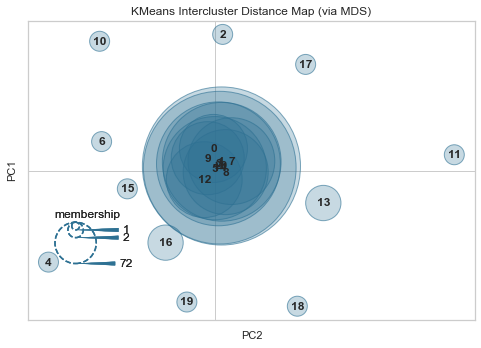

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [19]:
outpath=f"{save_prefix}EnglishChars_InterclusterDistance_k=21.png"
viz = yellowbrick.cluster.InterclusterDistance(KMeans(n_clusters=21,n_init=3,copy_x=True,algorithm='auto'))
viz.fit(pca_x)
viz.show(outpath=outpath)
viz.show()

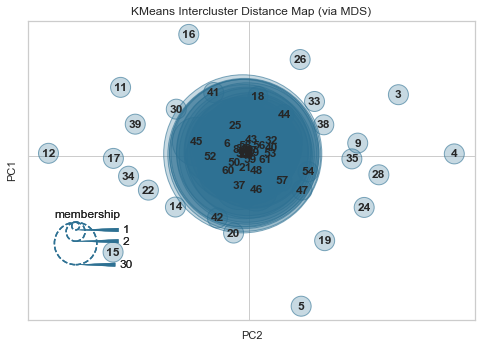

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [20]:
outpath=f"{save_prefix}EnglishChars_InterclusterDistance_k=62.png"
viz = yellowbrick.cluster.InterclusterDistance(KMeans(n_clusters=62,n_init=3,copy_x=True,algorithm='auto'))
viz.fit(pca_x)
viz.show(outpath=outpath)
viz.show()